# Capstone Project 2: Twitter Public Opinion Network Analysis for Bungie

This project's goal is to collect and analyze the available Twitter data for Bungie and their main game, Destiny 2.

The data are tweets about Bungie and Destiny 2 and the timelines (tweets made by) the Bungie and Destiny 2 official accounts.

This notebook is the exploratory data analysis for the project. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from datetime import datetime
import seaborn as sns
sns.set()

%load_ext watermark
%watermark

2019-05-02T11:46:39

CPython 2.7.15
IPython 5.8.0

compiler   : MSC v.1500 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [2]:
# These are the datetime columns
# Pandas can convert them all as-is
datetime_cols = ['created_at', 'quoted_status.created_at', 'retweeted_status.created_at']

In [3]:
destiny_2_tweet_min_df = pd.read_csv("../data/destiny_2_tweets_min.csv",
                                     encoding='utf-8', index_col=0, parse_dates=datetime_cols)
bungie_tweet_min_df = pd.read_csv("../data/bungie_tweets_min.csv",
                                  encoding='utf-8', index_col=0, parse_dates=datetime_cols)
bungie_timeline_min_df = pd.read_csv("../data/bungie_timeline_min.csv",
                                     encoding='utf-8', index_col=0, parse_dates=datetime_cols)
destiny_2_timeline_min_df = pd.read_csv("../data/destiny_2_timeline_min.csv",
                                        encoding='utf-8', index_col=0, parse_dates=datetime_cols)

## What variables are most important to the final question?

Retweet count, favorite count, tweet creation time

## Are there strong correlations between pairs of variables?

Tweets by official accounts and engagement on other accounts (time)?

## What are the appropriate tests to use to analyze these relationships?



#### User metrics

Track how many tweets each user has made, their follower count, avg # of retweets / favorites on a tweet.

Differentiate between bungie tweets and destiny tweets?

In [4]:
user_cols = ['user.id', 'user.name', 'user.followers_count', 'user.friends_count', 'user.statuses_count', 'user.verified']

twitter_users_df = pd.concat([destiny_2_tweet_min_df[user_cols], bungie_tweet_min_df[user_cols],
                              bungie_timeline_min_df[user_cols], destiny_2_timeline_min_df[user_cols]])
len(twitter_users_df)

46321

There were 46k tweets, but only by 25k different people.

In [5]:
twitter_users_df.drop_duplicates(subset=['user.id'], inplace=True)
twitter_users_df.set_index('user.id', drop=True, inplace=True)
twitter_users_df.sort_index(inplace=True)
twitter_users_df.index.name = 'user_id'
twitter_users_df.columns = ['name', 'follower_count', 'friend_count', 'status_count', 'verified']

print(len(twitter_users_df))
twitter_users_df.head()

25138


name  follower_count  friend_count  status_count  verified
user_id                                                                    
3124.0       Fobulous           388.0         319.0       24732.0     False
5177.0   Serdar Kiliç          1280.0         522.0       12769.0     False
12444.0        parody           457.0          86.0        1267.0     False
24713.0       Hoplite            30.0         102.0        1815.0     False
55343.0    Pier Luigi            78.0         217.0        1522.0     False

We now have a nice version of the information for each user in our dataset. Let's get some aggregate statistics.

Let's just make a version of the data that combines the two big dataframes.

In [6]:
all_tweets_df = pd.concat([destiny_2_tweet_min_df, bungie_tweet_min_df,
                           bungie_timeline_min_df, destiny_2_timeline_min_df]).drop_duplicates()

Get number of tweets, avg # retweets, avg # favorites, 

In [7]:
twitter_users_df['tweet_count'] = all_tweets_df.groupby('user.id').size()
twitter_users_df['avg_retweets'] = all_tweets_df.groupby('user.id')['retweet_count'].mean()
twitter_users_df['avg_favorites'] = all_tweets_df.groupby('user.id')['favorite_count'].mean()
twitter_users_df.head()

name  follower_count  friend_count  status_count  verified  \
user_id                                                                       
3124.0       Fobulous           388.0         319.0       24732.0     False   
5177.0   Serdar Kiliç          1280.0         522.0       12769.0     False   
12444.0        parody           457.0          86.0        1267.0     False   
24713.0       Hoplite            30.0         102.0        1815.0     False   
55343.0    Pier Luigi            78.0         217.0        1522.0     False   

         tweet_count  avg_retweets  avg_favorites  
user_id                                            
3124.0             1          15.0            0.0  
5177.0             1           0.0            0.0  
12444.0            1           1.0            0.0  
24713.0            1           0.0            0.0  
55343.0            7           0.0            0.0

The highest average number of favorites is 70 times the second highest number of favorites, and both are single tweets. That one has 3 times as many favorites as the next highest.

In [8]:
twitter_users_df.sort_values('avg_favorites').tail(10)

name  follower_count  friend_count  \
user_id                                                                
3.516223e+09               Fenty Stats         20199.0          81.0   
1.567159e+08                 100T Gigz         50756.0         590.0   
1.706460e+07               Rami Ismail        152346.0       11552.0   
7.033760e+17              Bungie Store         29271.0          12.0   
8.296731e+08            Danny Amendola        434314.0         459.0   
8.500834e+17                     Gladd         27878.0         524.0   
1.067160e+07               PlayStation      16136849.0         757.0   
9.484445e+08          Destiny The Game       2315365.0          25.0   
4.405465e+07  Hispanic at the Chris-co        171098.0         677.0   
4.140882e+09                    DrLupo       1006278.0         710.0   

              status_count  verified  tweet_count  avg_retweets  avg_favorites  
user_id                                                                         
3.516223e+09         960.0     False            1     160.00000     480.000000  
1.567159e+08       13974.0      True            1       4.00000     506.000000  
1.706460e+07       88122.0      True            4      89.25000     538.750000  
7.033760e+17         191.0     False            2     120.00000     589.000000  
8.296731e+08         639.0      True            1      33.00000     799.000000  
8.500834e+17        3236.0     False            8      27.87500     871.375000  
1.067160e+07       29575.0      True            2     112.00000     886.500000  
9.484445e+08        3572.0      True           54     244.87037    1145.092593  
4.405465e+07       33944.0     False            1     131.00000    2542.000000  
4.140882e+09       23954.0      True            1     265.00000   14363.000000

In [9]:
all_tweets_df[all_tweets_df['user.name'] == "DrLupo"].text.values

array([ u"Just want to say thanks to everyone who tunes in for the multitude of games I've been having fun playing on stream.\u2026 https://t.co/dMfjwJk4TN"], dtype=object)

The highest average retweet values are also single tweets, but are most closer together than the favorites. All of the highest retweets have 0 favorites, though. That is very strange.

In [10]:
twitter_users_df.sort_values('avg_retweets').tail(10)

name  follower_count  friend_count  status_count  \
user_id                                                                      
7.873572e+17    Destiny Ducote           115.0         659.0         960.0   
1.061948e+09           deyoncè           104.0         268.0        1378.0   
3.020224e+09           Destiny           278.0         642.0        5804.0   
3.733822e+09          D3S 🥀🗡            34.0          36.0         216.0   
2.894957e+09           destiny           519.0         696.0       26513.0   
3.914580e+08   Dessssssss 🖤🌺           828.0         562.0       32006.0   
7.385738e+17  destinyxjauregui            32.0         184.0         895.0   
2.218543e+09    Destiny Newman            29.0          53.0         477.0   
3.478825e+08            Dessss           929.0         791.0       67879.0   
8.555833e+17        palm.trees            40.0         105.0        1466.0   

              verified  tweet_count  avg_retweets  avg_favorites  
user_id                                                           
7.873572e+17     False            1       71572.0            0.0  
1.061948e+09     False            2       74336.0            0.0  
3.020224e+09     False            2       80648.0            0.0  
3.733822e+09     False            1       86535.0            0.0  
2.894957e+09     False            2       91272.0            0.0  
3.914580e+08     False            1      114015.0            0.0  
7.385738e+17     False            1      134966.0            0.0  
2.218543e+09     False            1      134967.0            0.0  
3.478825e+08     False            1      134970.0            0.0  
8.555833e+17     False            1      134972.0            0.0

I don't understand why this tweet got pulled.

I'm guessing the data acquisition was not 100% relevant. As long as it's not too much of my data, I should just be able to ignore it as noise.

In [11]:
all_tweets_df[all_tweets_df['user.name'] == "palm.trees"].text.values

array([ u'RT @ClimateBen: Remember:\r\r\r\n\r\r\r\n1. The oceans are being killed.\r\r\r\n2. Forests will soon be gone.\r\r\r\n3. Fertile soil is disappearing.\r\r\r\n4. Megafauna risk\u2026'], dtype=object)

How many tweets in my data have no retweets or favorites?

That's almost half of my data lol. Should I cull them? NO! Even if they don't have a big Twitter presence, those people are still important. Knowing how many people talk about your company / product requires tracking everyone, even if they don't add to your reach (leaves).

In [12]:
total = len(all_tweets_df)
num_responded = len(all_tweets_df[(all_tweets_df['retweet_count'] > 0) |
                                  (all_tweets_df['favorite_count'] > 0)])

print("Total Tweets: %d" % total)
print("Tweets with at least 1 favorite / retweet: %d" % num_responded)
print("Tweets with no favorites or retweets: %d" % (total - num_responded))

Total Tweets: 46321
Tweets with at least 1 favorite / retweet: 29193
Tweets with no favorites or retweets: 17128


In [13]:
nonzero_tweets_df = all_tweets_df[(all_tweets_df['retweet_count'] > 0) |
                                  (all_tweets_df['favorite_count'] > 0)]

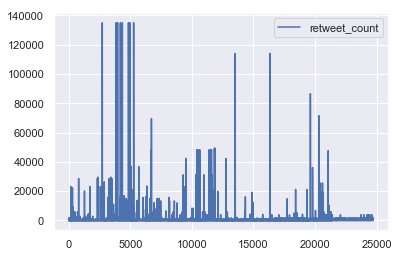

In [14]:
nonzero_tweets_df.plot(y='retweet_count')

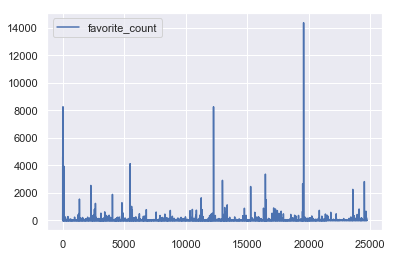

In [15]:
nonzero_tweets_df.plot(y='favorite_count')

#### To Do ?

Calculate time since official account tweeted. Make an exponential decay out of it? See if that improves the model.


D3 visualization of retweets, for what I have. It certainly isn't exhaustive.

### Twitter Presence of the Topics

As a function of time (grouped by the hour), see how many tweets go out and how many unique users tweet.

How many tweets? 

One of my dataframes does not quite extend back to March 4th, so the lower peaks are probably artificial.

It seems like peak Tweet times are evenings. Also, there appears to be less activity on the weekends. That's when everyone should be gaming!

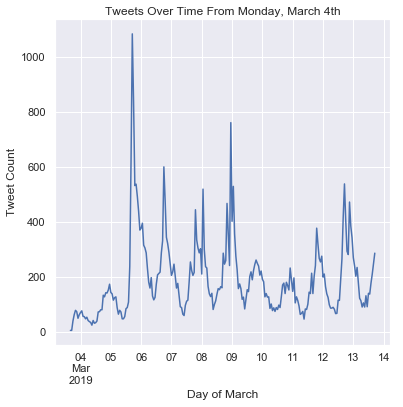

In [16]:
# The first 3 lines help get the vertical gridlines
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.grid.which'] = 'both'
matplotlib.rcParams['xtick.minor.visible'] = True
plt.rcParams["figure.figsize"] = (6,6)

_ = all_tweets_df.set_index('created_at', drop=True).resample('1H').size().plot()
_ = plt.xlabel('Day of March')
_ = plt.ylabel('Tweet Count')
_ = plt.title('Tweets Over Time From Monday, March 4th')
_ = plt.savefig('../analysis_images/tweets_over_time.png')

Wow! This plot is VERY similar to the last one. The counts are slightly smaller, so most people probably tweet no more than once in any given hour.

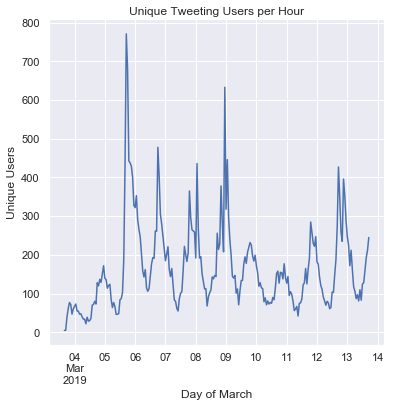

In [17]:
_ = all_tweets_df.set_index('created_at', drop=True)['user.id'].resample('1H').nunique().plot()
_ = plt.ylabel('Unique Users')
_ = plt.xlabel('Day of March')
_ = plt.title('Unique Tweeting Users per Hour')
_ = plt.savefig('../analysis_images/users_posting_over_time.png')

### Test for User Differences

We now have some basic statistics on users. We should compare users to see if all of the data can be represented by a simple statistical model.

First, get the standard deviation for each user's tweets' retweets and favorites.

Then, make it a 95% confidence interval by multiplying it by 1.96.



In [18]:
twitter_users_df.head()

name  follower_count  friend_count  status_count  verified  \
user_id                                                                       
3124.0       Fobulous           388.0         319.0       24732.0     False   
5177.0   Serdar Kiliç          1280.0         522.0       12769.0     False   
12444.0        parody           457.0          86.0        1267.0     False   
24713.0       Hoplite            30.0         102.0        1815.0     False   
55343.0    Pier Luigi            78.0         217.0        1522.0     False   

         tweet_count  avg_retweets  avg_favorites  
user_id                                            
3124.0             1          15.0            0.0  
5177.0             1           0.0            0.0  
12444.0            1           1.0            0.0  
24713.0            1           0.0            0.0  
55343.0            7           0.0            0.0

Standard deviation for a single point would technically be 0 (difference of the data point from the mean of the data point).

But that's not an accurate reflection of the spread.

In [19]:
twitter_users_df['std_retweets'] = all_tweets_df.groupby('user.id')['retweet_count'].std()
twitter_users_df['std_favorites'] = all_tweets_df.groupby('user.id')['favorite_count'].std()
twitter_users_df = twitter_users_df.fillna(value={"std_retweets": 0, "std_favorites": 0})

Get the confidence intervals

In [20]:
twitter_users_df['CI95_retweets'] = twitter_users_df['std_retweets'] * 1.96
twitter_users_df['CI95_favorites'] = twitter_users_df['std_favorites'] * 1.96

Well this isn't helpful. Time to log-log scale!

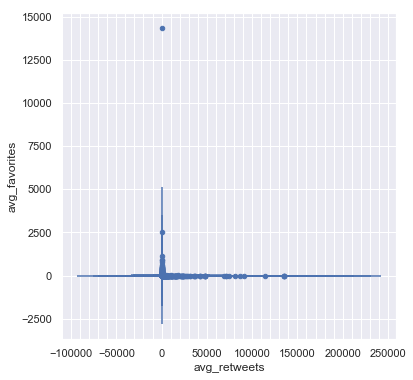

In [21]:
_ = twitter_users_df.plot.scatter(y='avg_favorites', x='avg_retweets', yerr='CI95_favorites', xerr='CI95_retweets')

This is very difficult to visualize. Maybe I should try a 1D version.

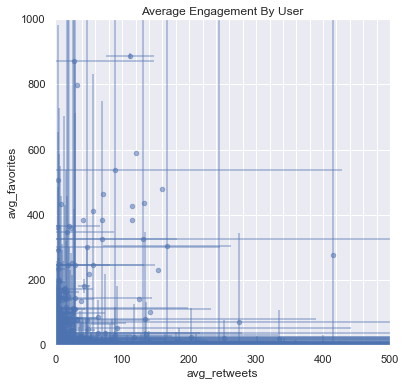

In [22]:
_ = twitter_users_df.plot.scatter(y='avg_favorites', x='avg_retweets',
                                  yerr='CI95_favorites', xerr='CI95_retweets',
                                  color='b', alpha=0.5)
_ = plt.xlim([0, 500])
_ = plt.ylim([0, 1000])
#_ = plt.yscale('log')
#_ = plt.xscale('log')
_ = plt.title('Average Engagement By User')

Much better

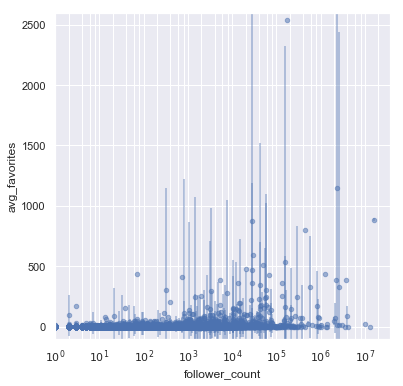

In [23]:
_ = twitter_users_df.plot.scatter(y='avg_favorites', x='follower_count',
                                  yerr='CI95_favorites',
                                  color='b', alpha=0.5)
_ = plt.xscale('log')
_ = plt.ylim([-100, 2600])

There are definitely some users whose error bars in average retweets/favorites encompass the whole distribution, and some whose error bars for those quantities are nonexistent (std 0).

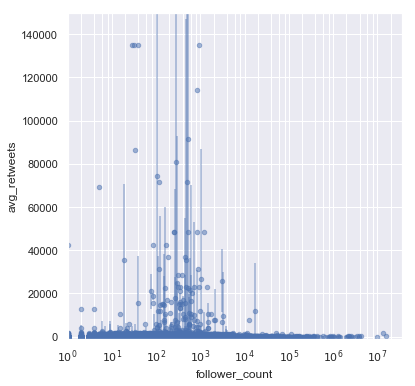

In [24]:
_ = twitter_users_df.plot.scatter(y='avg_retweets', x='follower_count',
                                  yerr='CI95_retweets',
                                  color='b', alpha=0.5)
_ = plt.xscale('log')
_ = plt.ylim([-1000, 150000])

Maybe it will be easier to visualize with only consistently active users with, say, at least 5 tweets.

Most of the data seems to be people with only a few tweets for this week.

I should still have a few thousand users to work with.

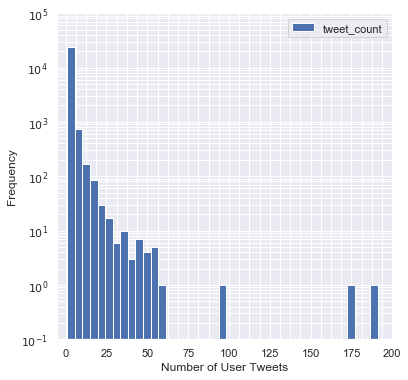

In [25]:
_ = twitter_users_df.plot.hist(y='tweet_count', bins=41)
_ = plt.yscale('log')
_ = plt.ylim([0.1, 100000])
_ = plt.xlim([-5, 200])
_ = plt.xlabel('Number of User Tweets')

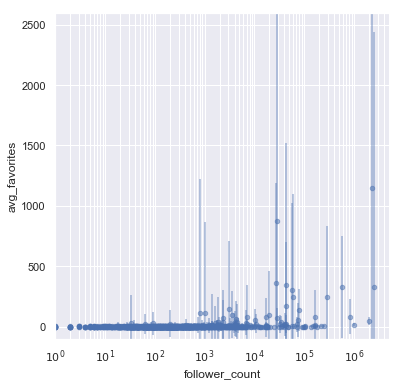

In [26]:
_ = twitter_users_df[twitter_users_df['tweet_count'] >= 5
                ].plot.scatter(y='avg_favorites', x='follower_count',
                               yerr='CI95_favorites',
                               color='b', alpha=0.5)
_ = plt.xscale('log')
_ = plt.ylim([-100, 2600])

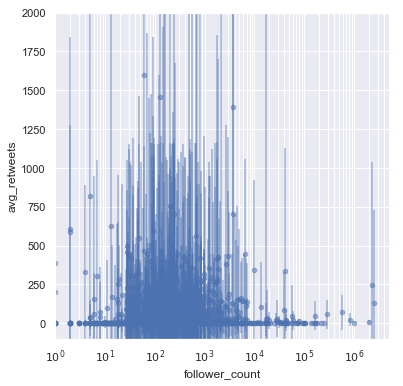

In [27]:
_ = twitter_users_df[twitter_users_df['tweet_count'] >= 5
                ].plot.scatter(y='avg_retweets', x='follower_count',
                               yerr='CI95_retweets',
                               color='b', alpha=0.5)
_ = plt.xscale('log')
_ = plt.ylim([-100, 2000])

It is still really hard to tell what is going on. I don't think I have the statistical strength to determine if users are different right now.

If I could to that, I'd be able to see users with non-overlapping y-error bars.

### Actually

I can filter the ones that won't have error bars that go through 0.

Since there are people with single tweets and no engagement, they will have averages of 0. If the 95% confidence interval on a user's average retweets / favorites goes through 0, then there isn't a clear statistical difference between that user and someone who has no engagement.

I can also require the confidence interval to have a non-zero length. This removes people with single tweets!

Now I can see that some of the users are definitely pulling more retweets. Since the error bars are the confidence intervals, if the error bars intersect, then I cannot claim that there is a statistically significant chance that the user's retweet averages are not due to random chance.

However, there are sets of error bars that do not intersect. Those users have less than a 5% chance of having differing average retweet amounts due to random chance.

It will be interesting to see if I can find the reason for the difference with NLP of the tweet text.

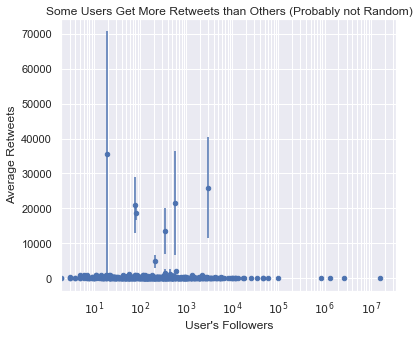

In [28]:
plt.rcParams["figure.figsize"] = (6,5)
_ = twitter_users_df[(twitter_users_df['avg_retweets'] > twitter_users_df['CI95_retweets']) &
                     (twitter_users_df['CI95_retweets'] != 0)
                    ].plot.scatter(x='follower_count', y='avg_retweets', yerr='CI95_retweets')
_ = plt.xscale('log')
_ = plt.ylabel('Average Retweets')
_ = plt.xlabel('User\'s Followers')
_ = plt.title('Some Users Get More Retweets than Others (Probably not Random)')
_ = plt.savefig('../analysis_images/retweets_vs_followers_per_user.png')

Zoomed-in version to look at the main distribution

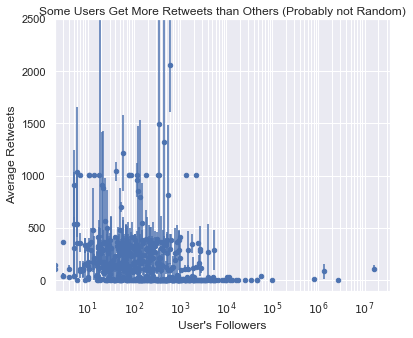

In [29]:
_ = twitter_users_df[(twitter_users_df['avg_retweets'] > twitter_users_df['CI95_retweets']) &
                     (twitter_users_df['CI95_retweets'] != 0)
                    ].plot.scatter(x='follower_count', y='avg_retweets', yerr='CI95_retweets')
_ = plt.xscale('log')
_ = plt.ylim([-100, 2500])
_ = plt.ylabel('Average Retweets')
_ = plt.xlabel('User\'s Followers')
_ = plt.title('Some Users Get More Retweets than Others (Probably not Random)')
_ = plt.savefig('../analysis_images/retweets_vs_followers_per_user_zoomed.png')

Let's check favorites now

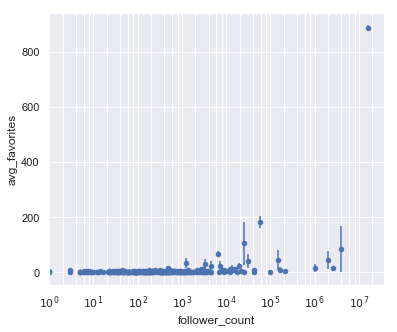

In [30]:
_ = twitter_users_df[(twitter_users_df['avg_favorites'] > twitter_users_df['CI95_favorites']) &
                     (twitter_users_df['CI95_favorites'] != 0)
                    ].plot.scatter(x='follower_count', y='avg_favorites', yerr='CI95_favorites')
_ = plt.xscale('log')

Zoomed-in version

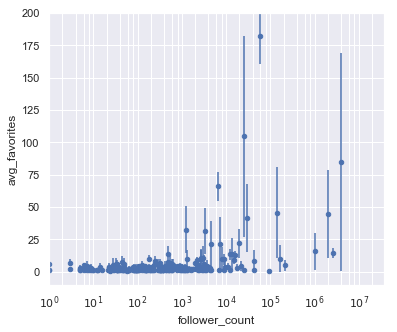

In [31]:
_ = twitter_users_df[(twitter_users_df['avg_favorites'] > twitter_users_df['CI95_favorites']) &
                     (twitter_users_df['CI95_favorites'] != 0)
                    ].plot.scatter(x='follower_count', y='avg_favorites', yerr='CI95_favorites')
_ = plt.xscale('log')
_ = plt.ylim([-10, 200])

### Challenge: Calculate the time since the last official tweet

Want to see if there is more engagement on average right after @Bungie or @DestinyTheGame tweets.

Make dataframe of normal tweets

Make dataframe of official tweets

for each normal tweet, get the time between it's posting and the most recent official account tweet

plot avg retweets / favorites normalized by follower count vs this time

In [32]:
normal_tweet_df = pd.concat([destiny_2_tweet_min_df, bungie_tweet_min_df]).reset_index(drop=True)
official_tweet_df = pd.concat([bungie_timeline_min_df, destiny_2_timeline_min_df]).reset_index(drop=True)
print(len(normal_tweet_df))

46168


Remove official account tweets from normal tweet dataframe

In [33]:
for user_id in official_tweet_df['user.id'].unique():
    normal_tweet_df = normal_tweet_df[normal_tweet_df['user.id'] != user_id]
print(len(normal_tweet_df))

46076


I can get timestamps

In [34]:
official_tweet_df.loc[0, 'created_at']

Timestamp('2019-03-13 17:21:12')

In [35]:
normal_tweet_df.loc[0, 'created_at']

Timestamp('2019-03-13 17:29:53')

I can subtract timestamps

In [36]:
normal_tweet_df['created_at'][0:5] - official_tweet_df['created_at'][0]

0   00:08:41
1   00:07:34
2   00:06:51
3   00:06:25
4   00:06:17
Name: created_at, dtype: timedelta64[ns]

.loc works as I want it to

Older timestamps are smaller values!!! Thus this subtraction gives a negative result. The Older tweet is "smaller" than the newer tweet.

In [37]:
official_tweet_df.loc[0, 'created_at'] - normal_tweet_df.loc[0, 'created_at']

Timedelta('-1 days +23:51:19')

In [38]:
official_tweet_df.loc[0, 'created_at'] > normal_tweet_df.loc[0, 'created_at']

False

This gets the oldest tweet in the official dataframe

In [39]:
official_tweet_df.sort_values('created_at').iloc[0, 1]

Timestamp('2019-03-03 22:02:50')

Define the function to make the new column

In [40]:
def set_time_since_official_tweet(original_df, official_df, time_col, new_col_name):
    """
    This function makes a column for the original dataframe
    This column will show the time since the most recent tweet in the official dataframe
    """
    
    # Make sure the original and official dfs are time-ordered
    original_df = original_df.sort_values(time_col)
    official_df = official_df.sort_values(time_col)
        
    # Loop
    for og_idx, tweet in original_df.iterrows():
        
        # There might be some tweets in the original df that are older than the oldest in the official df
        # In that case, just set the time diff to be it's posting time - the oldest time in official_df
        if (tweet[time_col] < official_df.iloc[0, 1]):
            original_df.loc[og_idx, new_col_name] = tweet[time_col] - official_df.iloc[0, 1]
            continue
        
        # This variable will hold the time differences between tweets
        # This is the max positive time difference, a good starting value for the minimum
        min_time_since_official_tweet = tweet[time_col] - official_df.iloc[-1, 1]
        
        # Find the closest tweet in official_df with a time less than this one
        for off_idx, official_tweet in official_df.iterrows():
            
            # Check if we've found an official tweet posted after the tweet in question
            if (official_tweet[time_col] > tweet[time_col]):                
                # The tweet before this official one is what we want
                break
                
            # Only set this if we didn't overstep
            min_time_since_official_tweet = tweet[time_col] - official_tweet[time_col]
            
        # Set the time difference
        original_df.loc[og_idx, new_col_name] = min_time_since_official_tweet
            
    return original_df

This takes a few minutes to run

In [41]:
%%time
normal_tweet_df = set_time_since_official_tweet(normal_tweet_df,
                                                official_tweet_df,
                                                'created_at',
                                                'time_since_official_tweet')

Wall time: 9min 36s


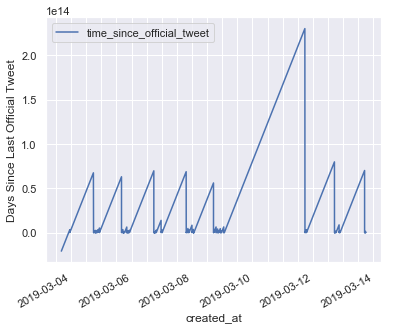

In [42]:
_ = normal_tweet_df.plot(x='created_at', y='time_since_official_tweet')
_ = plt.ylabel('Days Since Last Official Tweet')

In [43]:
print("Smallest Time Difference",
      normal_tweet_df['time_since_official_tweet'].sort_values()[21438])
print("Largest Time Difference",
      normal_tweet_df['time_since_official_tweet'].sort_values()[27189])

('Smallest Time Difference', Timedelta('-1 days +18:11:31'))
('Largest Time Difference', Timedelta('2 days 15:56:49'))


I can convert the timedelta column to minutes (float) so that the column is plottable.

Make a new column for it

In [44]:
normal_tweet_df['minutes_since_official_tweet'] = \
    normal_tweet_df['time_since_official_tweet'].astype('timedelta64[m]')

I want to plot retweets and favorites normalized by the follower base

In [45]:
normal_tweet_df['normalized_retweets'] = normal_tweet_df['retweet_count'] /\
                                            normal_tweet_df['user.followers_count']
normal_tweet_df['normalized_favorites'] = normal_tweet_df['favorite_count'] /\
                                            normal_tweet_df['user.followers_count']

There seems to be a slight negative relationship between the time since an official tweet and the normalized retweets. This suggests that tweeting right after an official account can boost your Twitter presence.

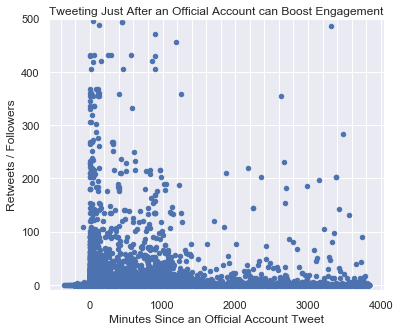

In [46]:
_ = normal_tweet_df.plot(x='minutes_since_official_tweet',
                         y='normalized_retweets', kind='scatter')
_ = plt.ylim([-10, 500])
_ = plt.ylabel('Retweets / Followers')
_ = plt.xlabel('Minutes Since an Official Account Tweet')
_ = plt.title('Tweeting Just After an Official Account can Boost Engagement')
_ = plt.savefig('../analysis_images/normalized_retweets_vs_time_delta.png')

The same relationship appears to hold for normalized favorites.

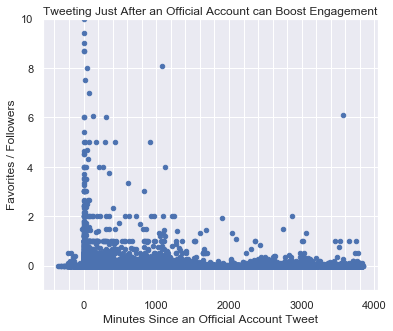

In [47]:
_ = normal_tweet_df.plot(x='minutes_since_official_tweet',
                         y='normalized_favorites', kind='scatter')
_ = plt.ylim([-1, 10])
_ = plt.ylabel('Favorites / Followers')
_ = plt.xlabel('Minutes Since an Official Account Tweet')
_ = plt.title('Tweeting Just After an Official Account can Boost Engagement')
_ = plt.savefig('../analysis_images/normalized_favorites_vs_time_delta.png')

### Basic Check: Trends within Official Tweets

I should see what engagement the official account tweets have for the week of data that is present.

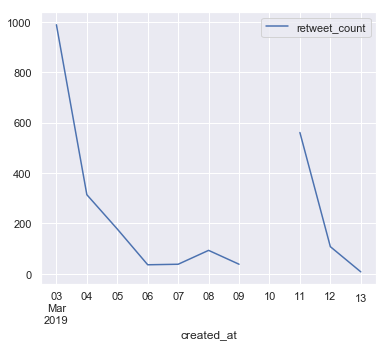

In [56]:
bungie_timeline_min_df.set_index('created_at', drop=True).resample('D').mean().plot(y='retweet_count')

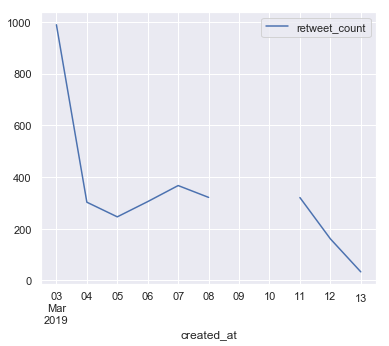

In [57]:
destiny_2_timeline_min_df.set_index('created_at', drop=True).resample('D').mean().plot(y='retweet_count')